1. Import necessary libraries and PORT-EK source code:

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import json
import pathlib
import pickle
import collections
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from Bio import SeqIO, Align
from matplotlib import colormaps
from scipy.stats import pearsonr
from datetime import datetime
#adding portek source directory to sys path before importing
portek_path = "../portek"
sys.path.insert(0,portek_path)
import portek

pd.options.mode.copy_on_write = True
print(os.getpid())


1282923


2. Declare data set specific definitions and functions:

In [123]:
# PORT-EK parameters
k = 11  # This is the length of k-mers
c = 0.19  # This is the conservation thershold used in k-mer rarity filter
m = 1  # This is the maximum number of mismatches allowed when re-examining rare k-mers
min_RMSE = 0.5  # This is the RMSE threshold used to select enriched k-mers

# Relative path to k-mer indices
INPUT_PATH = "../output/HIV/subB"

# Data set specific definitions of k-mer type, column names, reference gene and protein mapping, and colors for plots.
SAMPLE_GROUPS = ["Bmain", "Bout"]

FREQ_COLS = [f"{group}_freq" for group in SAMPLE_GROUPS]

AVG_COLS = [f"{group}_avg" for group in SAMPLE_GROUPS]

VOLCANO_CMAP = {
    "not significant": ("#DDDDDD", 0.5),
    "Bmain_enriched": ("#ffa401", 1),
    "Bout_enriched": ("#005ff5", 1),
}

HIV_GENES = {
    "5' LTR": (1, 634),
    "gag": (790, 2292),
    "pol": (2358, 5096),
    "vif": (5041, 5619),
    "vpr": (5559, 5795),
    "tat_1ex": (5831, 6045),
    "tat_2ex": (8379, 8653),
    "rev_1ex": (5970, 6045),
    "rev_2ex": (8379, 8653),
    "env": (6225, 8795),
    "nef": (8797, 9168),
    "3' LTR": (9086, 9719),
}

ref_seq = SeqIO.read("../input/HXB2.fasta", format="fasta").seq
aligner = Align.PairwiseAligner(
    # match_score=5,
    # mismatch_score=-4,
    # open_gap_score=-10,
    # extend_gap_score=-0.5,
    scoring="megablast",
    mode="local"
)


def assign_gene(ref_pos: list, gene_dict: dict) -> list:
    genes = []
    for start, end in ref_pos:
        for gene, gene_range in gene_dict.items():
            if (
                len(
                    [
                        pos
                        for pos in range(start, end + 1)
                        if pos in list(range(gene_range[0], gene_range[1] + 1))
                    ]
                )
                > 0
            ):
                genes.append(gene)

    return ", ".join(genes)

3. Construct k-mer count matrix and apply rarity filter

In [5]:
# First read all sample labels and k-mer sequences and construct an empty matrix. It requires significantly less memory than growing the matrix one-by-one.

# kmer_set = set()
# kmer_set_in_path = pathlib.Path(INPUT_PATH).glob(f"*{k}mer_set.pkl")
# for filename in kmer_set_in_path:
#     with open(filename, mode="rb") as in_file:
#         partial_set = pickle.load(in_file)
#     kmer_set.update(partial_set)

kmer_set = set(pd.read_csv("../output/HIV/scenario4/enriched_11mer_stat_matrix.csv", index_col=0).index)
kmer_set = set(portek.encode_kmer(kmer) for kmer in kmer_set)
sample_list = []
sample_list_in_path = pathlib.Path(INPUT_PATH).glob("*sample_list.pkl")
for filename in sample_list_in_path:
    with open(filename, mode="rb") as in_file:
        partial_list = pickle.load(in_file)
    group = filename.stem.split("_")[0]
    partial_list = [f"{group}_{sample_name}" for sample_name in partial_list]
    sample_list.extend(partial_list)
sample_list.sort()

all_kmer_matrix = pd.DataFrame(
    0, index=list(kmer_set), columns=sample_list, dtype="uint8"
)
group_sample_idx = {group:[] for group in SAMPLE_GROUPS}
for sample in sample_list:
    group_sample_idx[sample.split("_")[0]].append(sample)

print(f"\nImported {len(kmer_set)} kmers and {len(sample_list)} samples.")




Imported 6348 kmers and 11276 samples.


In [6]:
# Next, fill the table with k-mer counts.
counter = 1
tot_files = len(sample_list)
in_path = pathlib.Path(f"{INPUT_PATH}/{k}mer_indices").glob("*_count.pkl")

for filename in in_path:
    with open(filename, mode="rb") as in_file:
        temp_dict = pickle.load(in_file)
    sample_name = "_".join(filename.stem.split("_")[:-1])
    count_dict = {f"{sample_name}": temp_dict.values()}
    temp_df = pd.DataFrame(count_dict, index=temp_dict.keys(), dtype="uint8")
    all_kmer_matrix.update(temp_df)
    print(
        f"{counter} of {tot_files} indices done.",
        end="\r",
        flush=True,
    )
    counter += 1

# Decode k-mer sequences
all_kmer_matrix.index = all_kmer_matrix.index.map(lambda id: portek.decode_kmer(id,k))

# Construct a temporary binary count matrix, i.e. one that shows if a k-mer is present in sequence, without regards to actual count.
# Calculate k-mer frequencies and average counts in host groups.
bin_kmer_matrix = all_kmer_matrix > 0
for group in SAMPLE_GROUPS:
    all_kmer_matrix[f"{group}_freq"] = bin_kmer_matrix.loc[:, group_sample_idx[group]].mean(axis=1)
    all_kmer_matrix[f"{group}_avg"] = all_kmer_matrix.loc[:, group_sample_idx[group]].mean(axis=1)
del bin_kmer_matrix

# Remove polyA, as its presence and count is mostly dependant on sequencing quality not viral variant.
if "AAAAAAAAAAA" in all_kmer_matrix.index:
    all_kmer_matrix = all_kmer_matrix.drop("AAAAAAAAAAA")

# Apply rarity filter.
common_kmer_matrix = portek.filter_kmers(
    all_kmer_matrix, freq_cols=FREQ_COLS, cons_thr=c
)

print(
    f"\n{len(common_kmer_matrix)} common k-mers remaining after filtering at a threshold of {c}."
)

11276 of 11276 indices done.
3714 common k-mers remaining after filtering at a threshold of 0.19.


4. Calculate common k-mer statistics and identify host over-represented k-mers.

In [7]:
# Calculate mean k-mer count change, RMSE and test statistical significance.
common_kmer_matrix["seq"] = common_kmer_matrix.index
ERR_COLS = []
P_COLS = []
for j in range(1, len(SAMPLE_GROUPS)):
    for i in range(j):
        err_name = f"{SAMPLE_GROUPS[i]}-{SAMPLE_GROUPS[j]}_err"
        p_name = f"{SAMPLE_GROUPS[i]}-{SAMPLE_GROUPS[j]}_p-value"
        ERR_COLS.append(err_name)
        P_COLS.append(p_name)
        common_kmer_matrix[err_name] = (
            common_kmer_matrix[f"{SAMPLE_GROUPS[i]}_avg"]
            - common_kmer_matrix[f"{SAMPLE_GROUPS[j]}_avg"]
        )
        common_kmer_matrix[p_name] = common_kmer_matrix["seq"].apply(
            portek.calc_kmer_pvalue,
            args=(
                group_sample_idx[SAMPLE_GROUPS[i]],
                group_sample_idx[SAMPLE_GROUPS[j]],
                common_kmer_matrix,
            ),
        )
        common_kmer_matrix[f"-log10_{p_name}"] = -np.log10(common_kmer_matrix[p_name])
common_kmer_matrix["RMSE"] = np.sqrt(((common_kmer_matrix[ERR_COLS]) ** 2).mean(axis=1))


common_kmer_matrix = common_kmer_matrix.sort_values("RMSE", ascending=False)
common_kmer_matrix = common_kmer_matrix.drop("seq", axis=1)

# Identify host-overrepresented k-mers, according to the statistics calculated above.
common_kmer_matrix["group"] = common_kmer_matrix.apply(
    portek.assign_kmer_group, p_cols = P_COLS, avg_cols = AVG_COLS,axis=1
)
common_kmer_matrix["exclusivity"] = common_kmer_matrix.apply(
    portek.check_exclusivity, avg_cols = AVG_COLS, axis=1
)

# Make a separate DataFrame with just the statistics, without counts, for export and analysis.
common_kmer_stat_matrix = common_kmer_matrix.drop(sample_list, axis=1)


/home/labadmin/repos/PORT-EK 2/env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Optional: save/load k-mer count and statistics matrices. Uncomment the relevant lines to save/load particular files.

In [8]:
common_kmer_matrix.to_csv(f"../output/HIV/subB/common_{k}mer_count_matrix.csv")
common_kmer_stat_matrix.to_csv(f"../output/HIV/subB/common_{k}mer_stat_matrix.csv")
# all_kmer_matrix.to_csv(f"../output/HIV/subB/all_{k}mer_count_matrix.csv")

# common_kmer_matrix = pd.read_csv(f"../output/HIV/subB/common_{k}mer_count_matrix.csv", index_col=0)
# common_kmer_stat_matrix  = pd.read_csv(f"../output/HIV/subB/common_{k}mer_stat_matrix.csv", index_col=0)
# all_kmer_matrix= pd.read_csv(f"../output/HIV/subB/all_{k}mer_count_matrix.csv", index_col=0)

5. Visualize common k-mers using volcano plots. Uncomment the last line in each cell to save as svg.

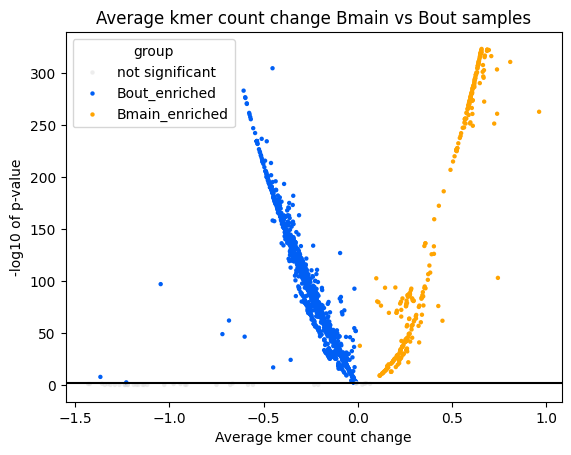

In [9]:
fig, ax = plt.subplots()
plt.axhline(y=-np.log10(0.01), color = 'black')
ax.autoscale()
ax.set_title('Average kmer count change Bmain vs Bout samples')
ax.set_xlabel('Average kmer count change')
ax.set_ylabel('-log10 of p-value')
sns.scatterplot(data=common_kmer_matrix, x='Bmain-Bout_err', y = '-log10_Bmain-Bout_p-value', s=10, linewidth = 0, hue='group', palette=VOLCANO_CMAP)
plt.savefig("../output/HIV/subB/volcano.svg", dpi = 600, format = "svg")

6. Optionally re-examin rare k-mers similar to over-represented k-mers. Run the two cells below only if you want to include potential rare, but still enriched k-mers in the analysis.

In [9]:
# # Select all rare k-mers that have higher average count in M, no matter the statistical significance.
# M_overrep_rare = all_kmer_matrix.loc[
#     (all_kmer_matrix["M_avg"] == all_kmer_matrix[AVG_COLS].max(axis=1))
# ]
# M_overrep_rare = M_overrep_rare[~M_overrep_rare.index.isin(M_overrep.index)]

# # Comment the following line to avoid lengthy k-mer similarity graph calculation
# M_overrep_similarity_graph = portek.build_similarity_graph_two_list(
#     M_overrep.index.tolist(), M_overrep_rare.index.tolist(), m
# )

# # Uncomment the first of the following blocks to save the graph as pickle file. Uncomment the second to load a previously calculated graph.

# with open(f"../output/HIV/scenario1/mor_{k}mer_{m}m.pickle", mode = "wb") as out_file:
#     pickle.dump(M_overrep_similarity_graph, out_file)

# # with open(f"../output/HIV/scenario1/mor_{k}mer_{m}m.pickle", mode = "rb") as in_file:
# #     M_overrep_similarity_graph = pickle.load(in_file)

# # Discard rare k-mers that are not in the similarity graph.
# M_overrep_rare = M_overrep_rare[
#     M_overrep_rare.index.isin(M_overrep_similarity_graph.nodes)
# ]

# # Calculate statistics and significance for rare k-mers similar to bat over-represented k-mers and choose the significant ones.
# # Calculation is identical to the one done for common k-mers.
# M_overrep_rare["M_err"] = M_overrep_rare["M_avg"] - M_overrep_rare["nonM_avg"]
# M_overrep_rare["M_RMSE"] = np.sqrt(((M_overrep_rare["M_err"]) ** 2))
# M_overrep_rare["seq"] = M_overrep_rare.index
# M_overrep_rare["p-value"] = M_overrep_rare["seq"].apply(
#     portek.calc_kmer_pvalue,
#     args=(M_sample_idx, nonM_sample_idx, M_overrep_rare),
# )

# M_overrep_rare = M_overrep_rare.sort_values("M_RMSE", ascending=False)
# M_overrep_rare = M_overrep_rare.drop("seq", axis=1)
# M_overrep_rare["-log10_p-value"] = -np.log10(M_overrep_rare["p-value"])
# M_overrep_rare["group"] = M_overrep_rare.apply(assign_kmer_type, axis=1)
# M_overrep_rare = M_overrep_rare[M_overrep_rare["group"] == "M over-represented"]
# M_overrep_all = pd.concat([M_overrep_rare, M_overrep])

In [10]:
# # See cell above for explanation. This cell has the same calculations, but done on nonM over-represented k-mers.
# nonM_overrep_rare = all_kmer_matrix.loc[
#     (all_kmer_matrix["M_avg"] == all_kmer_matrix[AVG_COLS].min(axis=1))
# ]
# nonM_overrep_rare = nonM_overrep_rare[~nonM_overrep_rare.index.isin(nonM_overrep.index)]

# # Comment the following line to avoid lengthy k-mer similarity graph calculation
# nonM_overrep_similarity_graph = portek.build_similarity_graph_two_list(
#     nonM_overrep.index.tolist(), nonM_overrep_rare.index.tolist(), m
# )

# # Uncomment the first of the following blocks to save the graph as pickle file. Uncomment the second to load a previously calculated graph.

# with open(f"../output/HIV/scenario1/nonmor_{k}mer_{m}m.pickle", mode = "wb") as out_file:
#     pickle.dump(nonM_overrep_similarity_graph, out_file)

# # with open(f"../output/HIV/scenario1/nonmor_{k}mer_{m}m.pickle", mode = "rb") as in_file:
# #     nonM_overrep_similarity_graph = pickle.load(in_file)

# nonM_overrep_rare = nonM_overrep_rare[
#     nonM_overrep_rare.index.isin(nonM_overrep_similarity_graph.nodes)
# ]

# nonM_overrep_rare["M_err"] = nonM_overrep_rare["M_avg"] - nonM_overrep_rare["nonM_avg"]
# nonM_overrep_rare["M_RMSE"] = np.sqrt(((nonM_overrep_rare["M_err"]) ** 2))
# nonM_overrep_rare["seq"] = nonM_overrep_rare.index
# nonM_overrep_rare["p-value"] = nonM_overrep_rare["seq"].apply(
#     portek.calc_kmer_pvalue,
#     args=(M_sample_idx, nonM_sample_idx, nonM_overrep_rare),
# )

# nonM_overrep_rare = nonM_overrep_rare.sort_values("M_RMSE", ascending=False)
# nonM_overrep_rare = nonM_overrep_rare.drop("seq", axis=1)
# nonM_overrep_rare["-log10_p-value"] = -np.log10(nonM_overrep_rare["p-value"])

# nonM_overrep_rare["group"] = nonM_overrep_rare.apply(assign_kmer_type, axis=1)
# nonM_overrep_rare = nonM_overrep_rare[
#     nonM_overrep_rare["group"] == "nonM over-represented"
# ]
# nonM_overrep_all = pd.concat([nonM_overrep_rare, nonM_overrep])

7. Find enriched k-mers by applying the RMSE filter. Export enriched k-mers for use in host classification.

In [10]:
# Take the over-represented k-mers that pass the RMSE filter. This generates of enriched k-mers identified by PORT-EK.

enriched_kmer_matrix = common_kmer_matrix[(common_kmer_matrix["group"] != "not significant") &(common_kmer_matrix["RMSE"]>min_RMSE)]
enriched_kmer_stat_matrix = enriched_kmer_matrix.drop(sample_list, axis=1)
enriched_kmers = {group:list(enriched_kmer_stat_matrix[enriched_kmer_stat_matrix["group"]==f"{group}_enriched"].index) for group in SAMPLE_GROUPS}
for group,kmers in enriched_kmers.items():
    print(f"{len(kmers)} {group}-enriched kmers found.")


def assign_host_numerical(sample_id):
    if sample_id in group_sample_idx["Bout"]:
        host = 1
    else:
        host = 0
    return host


# Prepare and save count matrix with host labels for use by classifiers that predict the most probalbe host of a viral sequence.
counts_for_classifier = enriched_kmer_matrix.T
counts_for_classifier.drop(common_kmer_stat_matrix.columns.difference(['group']), axis=0, inplace=True)
counts_for_classifier['host'] = counts_for_classifier.index.map(assign_host_numerical)

# counts_for_classifier.to_csv(f"../output/HIV/subB/{k}mer_counts_for_classifier.csv")
enriched_kmer_matrix.to_csv(f"../output/HIV/subB/enriched_{k}mer_count_matrix.csv")
enriched_kmer_stat_matrix.to_csv(f"../output/HIV/subB/enriched_{k}mer_stat_matrix.csv")

715 Bmain-enriched kmers found.
81 Bout-enriched kmers found.


8. Map enriched k-mers to the reference genome and identify host-enriched mutations.

In [144]:
mm = 2

mutations = {}
n_pos = []
ref_pos = []
matches = []

for kmer in enriched_kmer_matrix.index:
    
    alns = aligner.align(ref_seq, kmer)
    temp_n = 0
    temp_m = []
    temp_ref_pos = []

    for aln in alns:
            aln_length = len(aln.indices[1])
            adj_score = aln.score + ((k-aln_length)*-2)

            if adj_score>=k-3*mm:
                temp_n += 1
                temp_m.append(aln.counts()[1])
                temp_ref_pos.append((aln.indices[0][0]+1,aln.indices[0][-1]+1))
                if aln_length>=k:
                    for i in range(aln_length):
                        ref_nuc = aln[0][i]
                        kmer_nuc = aln[1][i]
                        if ref_nuc == "-":
                            mut_pos = aln.indices[0][i-1]+1
                        else:
                            mut_pos = aln.indices[0][i]+1
                        mut_pos = aln.indices[0][i]+1
                        if ref_nuc != kmer_nuc:
                            mutation = f"{ref_nuc}{mut_pos}{kmer_nuc}"
                            if mutation in mutations.keys():
                                mutations[mutation][kmer] = enriched_kmer_matrix.loc[kmer, "group"]
                            else:
                                mutations[mutation] = {kmer:enriched_kmer_matrix.loc[kmer, "group"]}
                else:
                    for i in range(k):
                        mut_pos_0 = aln.indices[0][0]-aln.indices[1][0]+i
                        ref_nuc = ref_seq[mut_pos_0]
                        kmer_nuc = kmer[i]
                        mut_pos = mut_pos_0+1
                        if ref_nuc != kmer_nuc:
                            mutation = f"{ref_nuc}{mut_pos}{kmer_nuc}"
                            if mutation in mutations.keys():
                                mutations[mutation][kmer] = enriched_kmer_matrix.loc[kmer, "group"]
                            else:
                                mutations[mutation] = {kmer:enriched_kmer_matrix.loc[kmer, "group"]}
    n_pos.append(temp_n)
    matches.append(temp_m)
    ref_pos.append(temp_ref_pos)

enriched_kmer_matrix["n_pos"] = n_pos
enriched_kmer_matrix["ref_pos"] = ref_pos
enriched_kmer_matrix["matches"] = matches
enriched_kmer_matrix["genes"] = enriched_kmer_matrix["ref_pos"].apply(assign_gene, args=[HIV_GENES])
enriched_kmer_stat_matrix = enriched_kmer_matrix.drop(sample_list, axis=1)
enriched_kmer_stat_matrix.to_csv(f"../output/HIV/subB/aligned_enriched_{k}mer_stat_matrix.csv")


mutations = {mut:kmers for mut, kmers in mutations.items() if len(kmers) > k//2 and len(set(kmers.values())) == 1}

In [155]:
mutations_id = list(mutations.keys())
mutations_ref_nuc = [mutid[0] for mutid in mutations_id]
mutations_mut_nuc = [mutid[1] for mutid in mutations_id]
mutations_ref_pos = [mutid[1:-1] for mutid in mutations_id]
mutations_groups = [list(mutations[mutid].values())[0] for mutid in mutations_id]
mutations_kmres = [list(mutations[mutid].keys()) for mutid in mutations_id]
mut_df = pd.DataFrame({"ref_nuc":mutations_ref_nuc, "ref_pos":mutations_ref_pos, "mut_nuc":mutations_mut_nuc, "group":mutations_groups,"kmers":mutations_kmres}, index=mutations_id).sort_values("ref_pos")
for group in SAMPLE_GROUPS:
    mut_df[f"{group}_agg_freq"] = mut_df["kmers"].apply(portek.calc_agg_freq, args=(group_sample_idx[group], enriched_kmer_matrix))

mut_df

,ref_nuc,ref_pos,mut_nuc,group,kmers,Bmain_agg_freq,Bout_agg_freq
T3800C,T,3800,3,Bmain_enriched,"[TCAATACCCCT, CAATACCCCTC, TGTCAATACCC, TTGTCA...",0.903103,0.0
C3866T,C,3866,3,Bmain_enriched,"[GAAACTTTCTA, AGCAGAAACTT, CTTTCTATGTA, TTTCTA...",0.796337,0.0
G5836T,G,5836,5,Bout_enriched,"[AAATGGATCCA, AGAAATGGATC, TGGATCCAGTA, ATGGAT...",0.136851,1.0
T8033C,T,8033,8,Bout_enriched,"[ACTCATCTGCA, GAAAACTCATC, AAAACTCATCT, AACTCA...",0.495397,1.0


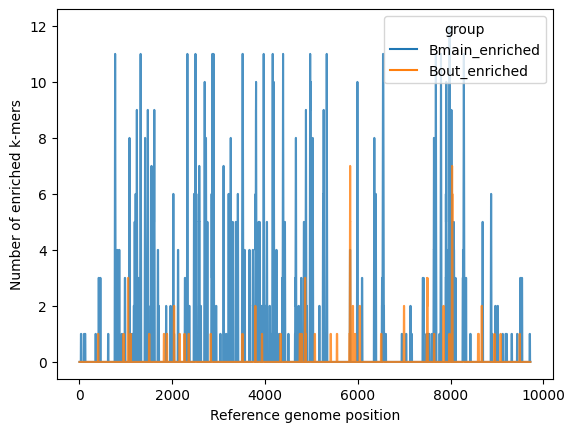

In [132]:
kmer_coverage = pd.DataFrame(0, index=pd.RangeIndex(1,len(ref_seq)), columns=["Bmain_enriched", "Bout_enriched"])

for kmer in enriched_kmer_matrix.index:
    group = enriched_kmer_matrix.loc[kmer, "group"]
    for position in enriched_kmer_matrix.loc[kmer, "ref_pos"]:
        kmer_coverage.loc[position[0]:position[1], group] += 1

kmer_coverage_long = pd.melt(kmer_coverage, ignore_index=False, var_name="group")

fig, ax = plt.subplots()
sns.lineplot(data = kmer_coverage_long, x=kmer_coverage_long.index, y="value", hue="group")
ax.set_xlabel("Reference genome position")
ax.set_ylabel("Number of enriched k-mers")
for line in ax.lines:
    line.set_alpha(0.8)

plt.savefig(f"../output/HIV/subB/enriched_{k}mer_coverage.svg", format="svg", dpi=600)

(0.0, 100.0)

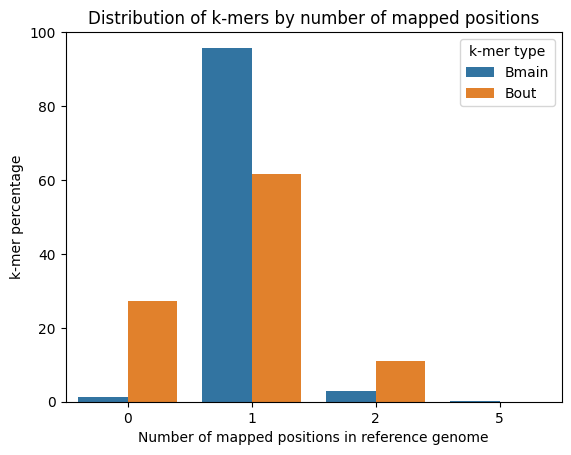

In [133]:
Bmain_dist = enriched_kmer_stat_matrix[enriched_kmer_stat_matrix["group"] == "Bmain_enriched"].value_counts("n_pos")/enriched_kmer_stat_matrix.value_counts('group')["Bmain_enriched"]*100
Bout_dist = enriched_kmer_stat_matrix[enriched_kmer_stat_matrix["group"] == "Bout_enriched"].value_counts("n_pos")/enriched_kmer_stat_matrix.value_counts('group')["Bout_enriched"]*100
dist = pd.concat([Bmain_dist, Bout_dist], axis=1, keys=["Bmain", "Bout"]).fillna(0).sort_index()
dist_longform = dist.melt(ignore_index=False, var_name="k-mer type")
fig, ax = plt.subplots()
sns.barplot(data = dist_longform, x = dist_longform.index, y="value", hue="k-mer type")
ax.set_title("Distribution of k-mers by number of mapped positions")
ax.set_ylabel("k-mer percentage")
ax.set_xlabel("Number of mapped positions in reference genome")
ax.set_ylim(0,100)


# plt.savefig(f"../output/HIV/scenario4/enriched_{k}mer_map_distr_variant2.svg", format="svg", dpi=600)

91

In [116]:
enriched_kmer_stat_matrix

,Bmain_freq,Bmain_avg,Bout_freq,Bout_avg,Bmain-Bout_err,Bmain-Bout_p-value,-log10_Bmain-Bout_p-value,RMSE,group,exclusivity,n_pos,ref_pos,matches,genes,gaps
CAGAGGAGAGC,0.492645,0.605106,1.000000,1.971583,-1.366477,1.926665e-08,7.715194,1.366477,Bout_enriched,non-exclusive,1,"[(5815, 5825)]",[11],,[0]
ACAGCCCCACC,0.726298,0.745184,1.000000,1.974290,-1.229106,3.391405e-03,2.469620,1.229106,Bout_enriched,non-exclusive,1,"[(2155, 2165)]",[11],gag,[0]
AGACATAATAG,0.858878,1.075543,0.001353,0.001353,1.074190,0.000000e+00,inf,1.074190,Bmain_enriched,non-exclusive,1,"[(4832, 4842)]",[11],pol,[0]
ACATCAGAAGG,0.499668,0.523204,1.000000,1.569689,-1.046485,9.924661e-98,97.003284,1.046485,Bout_enriched,non-exclusive,1,"[(946, 956)]",[11],gag,[0]
GACATAGTCAG,0.000095,0.000095,1.000000,1.000000,-0.999905,0.000000e+00,inf,0.999905,Bout_enriched,non-exclusive,1,"[(3078, 3085)]",[8],pol,[0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TAAAGAATTAC,0.495018,0.495587,1.000000,1.001353,-0.505766,1.963717e-215,214.706921,0.505766,Bout_enriched,non-exclusive,1,"[(4859, 4869)]",[11],pol,[0]
ATTTGCCAGGA,0.505172,0.505172,0.000000,0.000000,0.505172,1.073701e-215,214.969117,0.505172,Bmain_enriched,exclusive,1,"[(2363, 2372)]",[10],pol,[0]
CAGGCCAGACA,0.495777,0.495777,1.000000,1.000000,-0.504223,5.416166e-215,214.266308,0.504223,Bout_enriched,non-exclusive,1,"[(7842, 7852)]",[11],env,[0]
GGGGTGGGAAG,0.495967,0.495967,1.000000,1.000000,-0.504033,5.941341e-215,214.226116,0.504033,Bout_enriched,non-exclusive,1,"[(8588, 8598)]",[11],"tat_2ex, rev_2ex, env",[0]


In [127]:
mm = 4
mutations = {}
n_pos = []
ref_pos = []
kmer_pos =[]
matches = []
mismatches = []
gaps = []
for kmer in ["GACATAGTCAG"]:
    
    alns = aligner.align(ref_seq, kmer)
    temp_n = 0
    temp_m = []
    temp_mm = []
    temp_gap = []
    temp_ref_pos = []
    temp_kmer_pos = []

    for aln in alns:
        aln_length = len(aln.indices[1])
        adj_score = aln.score + ((k-aln_length)*-2)
        if adj_score>=k-3*mm:
            temp_n += 1
            temp_m.append(aln.counts()[1])
            temp_mm.append(aln.counts()[2])
            temp_gap.append(aln.counts()[0])
            temp_ref_pos.append((aln.indices[0][0]+1,aln.indices[0][-1]+1))
            temp_kmer_pos.append((aln.indices[1][0]+1,aln.indices[1][-1]+1))
            if aln_length>=k:
                for i in range(aln_length):
                    ref_nuc = aln[0][i]
                    kmer_nuc = aln[1][i]
                    mut_pos = aln.indices[0][i]+1
                    if ref_nuc != kmer_nuc:
                        mutation = f"{ref_nuc}{mut_pos}{kmer_nuc}"
                        if mutation in mutations.keys():
                            mutations[mutation].append(kmer)
                        else:
                            mutations[mutation] = [kmer]
            else:
                for i in range(k):
                    mut_pos_0 = aln.indices[0][0]-aln.indices[1][0]+i
                    ref_nuc = ref_seq[mut_pos_0]
                    kmer_nuc = kmer[i]
                    mut_pos = mut_pos_0+1
                    if ref_nuc != kmer_nuc:
                        mutation = f"{ref_nuc}{mut_pos}{kmer_nuc}"
                        if mutation in mutations.keys():
                            mutations[mutation].append(kmer)
                        else:
                            mutations[mutation] = [kmer]
    n_pos.append(temp_n)
    matches.append(temp_m)
    mismatches.append(temp_mm)
    gaps.append(temp_gap)
    ref_pos.append(temp_ref_pos)
    kmer_pos.append(temp_kmer_pos)

mutations

{'T3086C': ['GACATAGTCAG'], 'T3088G': ['GACATAGTCAG']}

In [119]:
ref_seq[3086]

'A'

In [88]:
print(len(aln.indices[1]))

12


9. Separate enriched k-mers into subtypes

In [ ]:
nonM_kmer_matrix = enriched_kmer_matrix.loc[enriched_kmer_matrix["group"] == "nonM_enriched", sample_list]
SAMPLE_SUBTYPES_NONM  = ["N","O","P"]
NONM_FREQ_COLS = [f"{group}_freq" for group in SAMPLE_SUBTYPES_NONM]
NONM_AVG_COLS = [f"{group}_avg" for group in SAMPLE_SUBTYPES_NONM]

bin_kmer_matrix = nonM_kmer_matrix > 0
for subtype in SAMPLE_SUBTYPES_NONM:
    nonM_kmer_matrix[f"{subtype}_freq"] = bin_kmer_matrix.loc[:, subtype_sample_idx[subtype]].mean(axis=1)
    nonM_kmer_matrix[f"{subtype}_avg"] = nonM_kmer_matrix.loc[:, subtype_sample_idx[subtype]].mean(axis=1)
del bin_kmer_matrix

# Calculate mean k-mer count change, RMSE and test statistical significance.
nonM_kmer_matrix["seq"] = nonM_kmer_matrix.index
NONM_ERR_COLS = []
NONM_P_COLS = []
for j in range(1, len(SAMPLE_SUBTYPES_NONM)):
    for i in range(j):
        err_name = f"{SAMPLE_SUBTYPES_NONM[i]}-{SAMPLE_SUBTYPES_NONM[j]}_err"
        p_name = f"{SAMPLE_SUBTYPES_NONM[i]}-{SAMPLE_SUBTYPES_NONM[j]}_p-value"
        NONM_ERR_COLS.append(err_name)
        NONM_P_COLS.append(p_name)
        nonM_kmer_matrix[err_name] = (
            nonM_kmer_matrix[f"{SAMPLE_SUBTYPES_NONM[i]}_avg"]
            - nonM_kmer_matrix[f"{SAMPLE_SUBTYPES_NONM[j]}_avg"]
        )
        nonM_kmer_matrix[p_name] = nonM_kmer_matrix["seq"].apply(
            portek.calc_kmer_pvalue,
            args=(
                subtype_sample_idx[SAMPLE_SUBTYPES_NONM[i]],
                subtype_sample_idx[SAMPLE_SUBTYPES_NONM[j]],
                nonM_kmer_matrix,
            ),
        )
        nonM_kmer_matrix[f"-log10_{p_name}"] = -np.log10(nonM_kmer_matrix[p_name])
nonM_kmer_matrix["RMSE"] = np.sqrt(((nonM_kmer_matrix[NONM_ERR_COLS]) ** 2).mean(axis=1))


nonM_kmer_matrix = nonM_kmer_matrix.sort_values("RMSE", ascending=False)
nonM_kmer_matrix = nonM_kmer_matrix.drop("seq", axis=1)

# Identify host-overrepresented k-mers, according to the statistics calculated above.
nonM_kmer_matrix["group"] = nonM_kmer_matrix.apply(
    portek.assign_kmer_group, p_cols = NONM_P_COLS, avg_cols = NONM_AVG_COLS,axis=1
)
nonM_kmer_matrix.loc[nonM_kmer_matrix["group"] == "not significant", "group"] = "nonM_enriched"
nonM_kmer_matrix["exclusivity"] = nonM_kmer_matrix.apply(
    portek.check_exclusivity, avg_cols = NONM_AVG_COLS, axis=1
)

# Make a separate DataFrame with just the statistics, without counts, for export and analysis.
nonM_kmer_stat_matrix = nonM_kmer_matrix.drop(sample_list, axis=1)
nonM_kmer_stat_matrix["group"].value_counts()

In [ ]:
nonM_kmer_stat_matrix

In [ ]:
kmer_coverage = pd.DataFrame(0, index=pd.RangeIndex(1,len(ref_seq)), columns=["N_enriched", "O_enriched", "P_enriched", "nonM_enriched"])

for kmer in nonM_kmer_matrix.index:
    group = nonM_kmer_matrix.loc[kmer, "group"]
    for position in enriched_kmer_matrix.loc[kmer, "ref_pos"]:
        kmer_coverage.loc[position[0]:position[1], group] += 1

kmer_coverage_long = pd.melt(kmer_coverage, ignore_index=False, var_name="group")

fig, ax = plt.subplots()
sns.lineplot(data = kmer_coverage_long, x=kmer_coverage_long.index, y="value", hue="group")
ax.set_xlabel("Reference genome position")
ax.set_ylabel("Number of enriched k-mers")
for line in ax.lines:
    line.set_alpha(0.6)

In [ ]:
M_kmer_matrix = enriched_kmer_matrix.loc[enriched_kmer_matrix["group"] == "M_enriched", sample_list]
SAMPLE_SUBTYPES_M  = ["MA","MB","MC","MD","Mrest"]
M_FREQ_COLS = [f"{group}_freq" for group in SAMPLE_SUBTYPES_M]
M_AVG_COLS = [f"{group}_avg" for group in SAMPLE_SUBTYPES_M]

bin_kmer_matrix = M_kmer_matrix > 0
for subtype in SAMPLE_SUBTYPES_M:
    M_kmer_matrix[f"{subtype}_freq"] = bin_kmer_matrix.loc[:, subtype_sample_idx[subtype]].mean(axis=1)
    M_kmer_matrix[f"{subtype}_avg"] = M_kmer_matrix.loc[:, subtype_sample_idx[subtype]].mean(axis=1)
del bin_kmer_matrix

# Calculate mean k-mer count change, RMSE and test statistical significance.
M_kmer_matrix["seq"] = M_kmer_matrix.index
M_ERR_COLS = []
M_P_COLS = []
for j in range(1, len(SAMPLE_SUBTYPES_M)):
    for i in range(j):
        err_name = f"{SAMPLE_SUBTYPES_M[i]}-{SAMPLE_SUBTYPES_M[j]}_err"
        p_name = f"{SAMPLE_SUBTYPES_M[i]}-{SAMPLE_SUBTYPES_M[j]}_p-value"
        M_ERR_COLS.append(err_name)
        M_P_COLS.append(p_name)
        M_kmer_matrix[err_name] = (
            M_kmer_matrix[f"{SAMPLE_SUBTYPES_M[i]}_avg"]
            - M_kmer_matrix[f"{SAMPLE_SUBTYPES_M[j]}_avg"]
        )
        M_kmer_matrix[p_name] = M_kmer_matrix["seq"].apply(
            portek.calc_kmer_pvalue,
            args=(
                subtype_sample_idx[SAMPLE_SUBTYPES_M[i]],
                subtype_sample_idx[SAMPLE_SUBTYPES_M[j]],
                M_kmer_matrix,
            ),
        )
        M_kmer_matrix[f"-log10_{p_name}"] = -np.log10(M_kmer_matrix[p_name])
M_kmer_matrix["RMSE"] = np.sqrt(((M_kmer_matrix[M_ERR_COLS]) ** 2).mean(axis=1))


M_kmer_matrix = M_kmer_matrix.sort_values("RMSE", ascending=False)
M_kmer_matrix = M_kmer_matrix.drop("seq", axis=1)

# Identify host-overrepresented k-mers, according to the statistics calculated above.
M_kmer_matrix["group"] = M_kmer_matrix.apply(
    portek.assign_kmer_group, p_cols = M_P_COLS, avg_cols = M_AVG_COLS,axis=1
)
M_kmer_matrix.loc[M_kmer_matrix["group"] == "not significant", "group"] = "M_enriched"
M_kmer_matrix["exclusivity"] = M_kmer_matrix.apply(
    portek.check_exclusivity, avg_cols = M_AVG_COLS, axis=1
)

# Make a separate DataFrame with just the statistics, without counts, for export and analysis.
M_kmer_stat_matrix = M_kmer_matrix.drop(sample_list, axis=1)
M_kmer_stat_matrix["group"].value_counts()

In [ ]:
kmer_coverage = pd.DataFrame(0, index=pd.RangeIndex(1,len(ref_seq)), columns=["MA_enriched", "MB_enriched", "MC_enriched","MD_enriched","Mrest_enriched", "M_enriched"])

for kmer in M_kmer_matrix.index:
    group = M_kmer_matrix.loc[kmer, "group"]
    for position in enriched_kmer_matrix.loc[kmer, "ref_pos"]:
        kmer_coverage.loc[position[0]:position[1], group] += 1

kmer_coverage_long = pd.melt(kmer_coverage, ignore_index=False, var_name="group")

fig, ax = plt.subplots()
sns.lineplot(data = kmer_coverage_long, x=kmer_coverage_long.index, y="value", hue="group")
ax.set_xlabel("Reference genome position")
ax.set_ylabel("Number of enriched k-mers")
for line in ax.lines:
    line.set_alpha(0.6)

In [ ]:
subtype_enriched_kmer_matrix = pd.concat([M_kmer_matrix, nonM_kmer_matrix])
subtype_enriched_kmer_stat_matrix= subtype_enriched_kmer_matrix.drop(sample_list, axis=1)

def assign_host_numerical(sample_id):
    subtype = sample_id.split("_")[0]
    numeric_subtypes = {"MA":0, "MB":1, "MC":2, "MD":3, "Mrest":4, "N":5, "O":6, "P":7, "group":-1, "exclusivity":-1}
    return numeric_subtypes[subtype]


# Prepare and save count matrix with host labels for use by classifiers that predict the most probalbe host of a viral sequence.
counts_for_classifier = subtype_enriched_kmer_matrix.T
counts_for_classifier.drop(subtype_enriched_kmer_stat_matrix.columns.difference(['group', "exclusivity"]), axis=0, inplace=True)
counts_for_classifier['host'] = counts_for_classifier.index.map(assign_host_numerical)

counts_for_classifier.to_csv(f"../output/HIV/scenario4/{k}mer_counts_for_subtype_classifier.csv")
# enriched_kmer_matrix.to_csv(f"../output/HIV/scenario4/enriched_{k}mer_count_matrix.csv")
# enriched_kmer_stat_martix.to_csv(f"../output/HIV/scenario4/enriched_{k}mer_stat_matrix.csv")